In [140]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 12, 4
import timeit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection, metrics
from sklearn.grid_search import GridSearchCV # perform grid search
from sklearn.model_selection import KFold 
import xgboost as xgb
from datetime import datetime

# Load Data

In [142]:
train_df = pd.read_csv("train.csv", header=0)
test_df = pd.read_csv("test.csv", header = 0)

# convert datetime column into multiple columns (year/month/day/hour/weekday)
dt = pd.to_datetime(train_df["datetime"]) # convert string to datetime type
train_df["year"] = dt.map(lambda x: x.year) 
train_df["month"] = dt.map(lambda x: x.month)
train_df["day"] = dt.map(lambda x: x.day)
train_df["hour"] = dt.map(lambda x: x.hour)
train_df["weekday"] = dt.map(lambda x: x.weekday())
train_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5


In [143]:
# convert datetime column into multiple columns (year/month/day/hour/weekday)
dt = pd.to_datetime(test_df["datetime"]) # convert string to datetime type
test_df["year"] = dt.map(lambda x: x.year) 
test_df["month"] = dt.map(lambda x: x.month)
test_df["day"] = dt.map(lambda x: x.day)
test_df["hour"] = dt.map(lambda x: x.hour)
test_df["weekday"] = dt.map(lambda x: x.weekday())
test_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3


## Remove outliers 
From the figure Perceived Temerature VS Actual Temperature, there are some points far away from the diagonal line. Therefore, we remove the data points in the following steps.

In [144]:
train_clean = train_df[np.array(train_df["temp"]/train_df["atemp"])<2]

In [151]:
train_all = train_clean

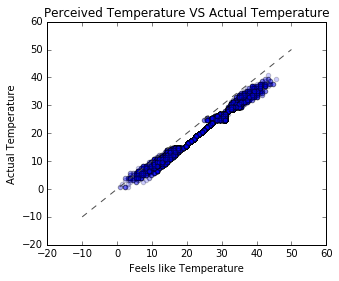

In [152]:
f, ax = plt.subplots(figsize=(5, 4))
ax.scatter(train_clean["atemp"], train_clean["temp"], alpha = 0.2)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", color = "red")
ax.set_xlabel("Feels like Temperature")
ax.set_ylabel("Actual Temperature")
plt.title("Perceived Temperature VS Actual Temperature")
plt.show()

# Model Training

##  Feature Engineer
In the following section, We conducted one-hot-encoding to converse all categorical variables into binary arrays.

In [153]:
# weekday is dropped because it overlaps with workingday
# temp is dropped because it overlaps with atemp
# registered and casual are dropped because they should be response variable
train_all = train_all.drop(['datetime', 'weekday', 'temp', 'registered', 'casual'],axis = 1) # include all features and target
train_all.head(3)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,13.635,80,0.0,32,2011,1,1,2


In [7]:
test_all = test_df.drop(['datetime', 'weekday', 'temp'],axis = 1) # include all features and target
test_all.head(3) # features for testing model

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,13.635,56,0.0000,2011,1,20,1
2,1,0,1,1,13.635,56,0.0000,2011,1,20,2


In the above table, conduct one-hot-encoding for "season", "holiday", "workingday", "weather"

In [154]:
encode_feature = train_all[['season','holiday','workingday','weather']].values
enc = OneHotEncoder()
encode_result = enc.fit_transform(encode_feature).toarray()
print "encoded results for the first four categorical features: ", "\n"
print encode_result, np.shape(encode_result), "\n"

after_encode = np.concatenate([encode_result,train_all.ix[:, 4:]], axis = 1)
print "combine encoded features with other numerical features: ", "\n"
print after_encode, np.shape(after_encode), "\n"

col_names = train_all.columns
print col_names

encoded results for the first four categorical features:  

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] (10862, 12) 

combine encoded features with other numerical features:  

[[  1.   0.   0. ...,   1.   1.   0.]
 [  1.   0.   0. ...,   1.   1.   1.]
 [  1.   0.   0. ...,   1.   1.   2.]
 ..., 
 [  0.   0.   0. ...,  12.  19.  21.]
 [  0.   0.   0. ...,  12.  19.  22.]
 [  0.   0.   0. ...,  12.  19.  23.]] (10862, 20) 

Index([u'season', u'holiday', u'workingday', u'weather', u'atemp', u'humidity',
       u'windspeed', u'count', u'year', u'month', u'day', u'hour'],
      dtype='object')


In [155]:
train_target_encode = after_encode[:, -5]
train_feature_encode = np.concatenate([after_encode[:,0:-5], after_encode[:,-4:]], axis = 1)

## Train Test Split
### Version 1: without one-hot-encoding train test split

In [160]:
# train and test split. 2:1. 11 features in total. 
# train: 2d array
# test: 2d array
temp = train_all.values
header1 = list(col_names)
print header1

train_size = int(temp.shape[0]*0.67)

train_sample_indices = random.sample(range(temp.shape[0]),train_size) # random sample from temp data. No replacement
data1 = temp[train_sample_indices,:]

validation_sample_indices = [i for i in range(temp.shape[0]) if i not in train_sample_indices]
data2 = temp[validation_sample_indices,:]

header2 = header1

train_target = temp[train_sample_indices, header1.index('count')].astype(int) # target value for train data
train_feature = np.delete(data1, header1.index('count'), axis = 1) # all features for model input
test_target = temp[validation_sample_indices, header2.index('count')].astype(int) # target value for validation data
test_feature = np.delete(data2, header2.index('count'), axis = 1) 

assert(np.shape(train_feature)[0] + np.shape(test_feature)[0] == np.shape(temp)[0]) # makesure the split is right
header1.remove('count')
print "train target shape: ", np.shape(train_target)
print "train shape: ", np.shape(train_feature)
print "test target shape: ", np.shape(test_target)
print "test shape: ", np.shape(test_feature)
print "before split shape: ", np.shape(temp)

['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour']
train target shape:  (7277,)
train shape:  (7277, 11)
test target shape:  (3585,)
test shape:  (3585, 11)
before split shape:  (10862, 12)


### version 2: with one-hot-encoding train test split

In [168]:
# train test split. 19 features in total
# after encoded. 2d array
full_train_target_encode = after_encode[:, -5]
full_train_feature_encode = np.concatenate([after_encode[:,0:-5], after_encode[:,-4:]], axis = 1)


train_size = int(full_train_feature_encode.shape[0]*0.67)

train_sample_indices = random.sample(range(full_train_feature_encode.shape[0]),train_size) # random sample from temp data. No replacement
data1 = temp[train_sample_indices,:]

validation_sample_indices = [i for i in range(full_train_feature_encode.shape[0]) if i not in train_sample_indices]
data2 = temp[validation_sample_indices,:]


train_target_encode = full_train_target_encode[train_sample_indices].astype(int) # target value for train data
train_feature_encode = full_train_feature_encode[train_sample_indices] # all features for model input
test_target_encode = full_train_target_encode[validation_sample_indices].astype(int) # target value for validation data
test_feature_encode = full_train_feature_encode[validation_sample_indices]

assert(np.shape(train_feature_encode)[0] + np.shape(test_feature_encode)[0] == np.shape(full_train_feature_encode)[0]) # makesure the split is right

print "encoded train target shape: ", np.shape(train_target_encode)
print "encoded train shape: ", np.shape(train_feature_encode) # all features for model input
print "encoded test target shape: ", np.shape(test_target_encode)
print "encoded test shape: ", np.shape(test_feature_encode)
# print "encoded before split shape: ", np.shape(temp)

 encoded train target shape:  (7277,)
encoded train shape:  (7277, 19)
encoded test target shape:  (3585,)
encoded test shape:  (3585, 19)


#### Here we have all training data and testing data. Ready to GO!
## Define evaluation function

In [161]:
# Evaluation
def cal_rmlse(pred, actual):
    """
    evaluation of model
    parameters:
    -----------
    pred: array or list
        prediction
    actual: array or list
        actual target value
    return:
    -----------
    rmlse
    """
    rmlse = np.sqrt(np.mean((np.log(np.array(pred) + 1)- np.log(np.array(actual) + 1))**2))
    return rmlse
# test example
cal_rmlse([1,2,3],[2,6,2])

0.56717915832655263

## Model 1: Linear Regression
### pair-wise scatter plot

In [13]:
X = sm.add_constant(train2)
result = sm.OLS(train_target2, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     415.6
Date:                Mon, 22 May 2017   Prob (F-statistic):               0.00
Time:                        15:43:50   Log-Likelihood:                -46483.
No. Observations:                7293   AIC:                         9.299e+04
Df Residuals:                    7281   BIC:                         9.307e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -1.671e+05   6731.419    -24.818      0.000      -1.8e+05 -1.54e+05
x1           -11.5857      6.339     -1.828      0.068       -24.013     0.841
x2            -0.6858     10.461     -0.066      0.948       -21.192    19.820
x3             0.7254      3.683      0.197      0.844        -6.494     7.945
x4            -2.9423      2.919     -1.008      0.314        -8.665     2.780
x5             5.9979      0.207     28.908      0.000         5.591     6.405
x6            -2.0802      0.106    -19.555      0.000        -2.289    -1.872
x7             0.6068      0.218      2.788      0.005         0.180     1.033
x8            83.0699      3.346     24.825      0.000        76.510    89.630
x9            11.7084      2.059      5.687      0.000         7.672    15.744
x10            0.2764      0.304      0.909      0.363        -0.320     0.872
x11            7.7200      0.254     30.383      0.000         7.222     8.218
==============================================================================
Omnibus:                     1444.052   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2798.743
Skew:                           1.204   Prob(JB):                         0.00
Kurtosis:                       4.846   Cond. No.                     8.15e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### remove insignificant variables one by one and see other variables' significance

In [14]:
X = sm.add_constant(train2[:, [4,5,6,7,8,9,10]])
result = sm.OLS(train_target2, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     652.3
Date:                Mon, 22 May 2017   Prob (F-statistic):               0.00
Time:                        15:43:51   Log-Likelihood:                -46485.
No. Observations:                7293   AIC:                         9.299e+04
Df Residuals:                    7285   BIC:                         9.304e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -1.67e+05   6725.225    -24.832      0.000      -1.8e+05 -1.54e+05
x1             5.9931      0.207     28.943      0.000         5.587     6.399
x2            -2.1217      0.096    -22.136      0.000        -2.310    -1.934
x3             0.5816      0.215      2.701      0.007         0.160     1.004
x4            83.0364      3.343     24.837      0.000        76.483    89.590
x5             8.1020      0.518     15.643      0.000         7.087     9.117
x6             0.2722      0.304      0.896      0.371        -0.324     0.868
x7             7.7027      0.253     30.463      0.000         7.207     8.198
==============================================================================
Omnibus:                     1448.774   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2814.097
Skew:                           1.207   Prob(JB):                         0.00
Kurtosis:                       4.853   Cond. No.                     8.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train2[:, [4,5,6,7,8,9,10]], train_target2)
print lr.coef_

[  5.9930866   -2.12168379   0.58159473  83.03638176   8.10203909
   0.27220823   7.70267321]


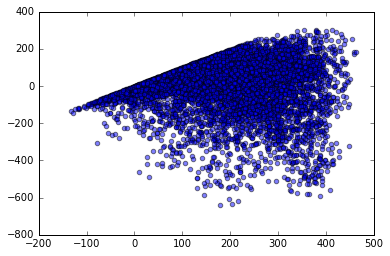

In [16]:
plt.scatter(lr.predict(train2[:, [4,5,6,7,8,9,10]]), lr.predict(train2[:, [4,5,6,7,8,9,10]])-train_target2, 
            alpha = 0.5)
plt.show()

diagnostics looks not good

### Baseline

In [17]:
# calculate error of predicting baseline (everyday count of rental is the same, 
# which is the average demand of training data)
kf = KFold(n_splits=10, random_state=200, shuffle=False)     
rmlse_ls = []
for train_index, test_index in kf.split(train_feature):
    X_train, X_test = train_feature[train_index], train_feature[test_index]
    y_train, y_test = train_target[train_index], train_target[test_index]
    rmlse = cal_rmlse(np.mean(y_train), y_test)
    rmlse_ls.append(rmlse)
print "baseling rmlse: ", np.mean(rmlse_ls)

baseling rmlse:  1.56213879394


## Model 2: Random Forests

In [67]:
def cv_fit_pred(model, fold, train_feature, train_target):
    kf = KFold(n_splits=10, random_state=200, shuffle=True)
    gb_rmlse_ls = []
    for train_index, test_index in kf.split(train_feature):
        X_train, X_test = train_feature[train_index], train_feature[test_index]
        y_train, y_test = train_target[train_index], train_target[test_index]
    #     print np.shape(X_train), np.shape(X_test), np.shape(y_train)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = [0 if i < 0 else i for i in pred]
        rmlse = cal_rmlse(pred, y_test)
    #     print "rmlse for this fold: ", rmlse
        gb_rmlse_ls.append(rmlse)
    return np.mean(gb_rmlse_ls)

### Fit Random Forests

In [173]:
# sample_leaf selection
# choose 2
sample_leaf = range(1,10)
for s in sample_leaf:
    rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=0, max_features='auto',
                                min_samples_leaf = s, oob_score=True)
    print s, cv_fit_pred(rf, 10, train_feature, train_target)

1 0.365223403686
2 0.364858610949
3 0.368013413812
4 0.372613309061
5 0.37667504662
6 0.381781671524
7

KeyboardInterrupt: 

In [176]:
# n_estimators selection
# choose 2
estimators = range(100,500,50)
for s in estimators:
    rf = RandomForestRegressor(n_estimators=s, max_depth=None, random_state=0, max_features='auto',
                                min_samples_leaf = 2, oob_score=True)
    print s, cv_fit_pred(rf, 10, train_feature, train_target)

 100 0.365614394685
150 0.364810018536
200 0.364858610949
250 0.364597869776
300 0.364439276433
350 0.364169056634
400 0.364144472101
450 0.363944520717


#### Final Parameters: n_estimators = 300, max_depth = None, n_jobs = -1,random_state =0, max_features = "auto", min_samples_leaf = 2

In [179]:
model = RandomForestRegressor(n_estimators = 300, max_depth = None, n_jobs = -1,random_state =0,
                              max_features = "auto", min_samples_leaf = 2)
print "cross-validation error: ", cv_fit_pred(model, 10, train_feature, train_target)
pred = model.predict(test_feature)
rmlse = cal_rmlse(pred, test_target)
print "RMLSE on testing dataset: ", rmlse

cross-validation error:  0.364439276433
RMLSE on testing dataset:  0.359584063223


In [180]:
# one-hot-encoding prediction results
model = RandomForestRegressor(n_estimators = 300, max_depth = None, n_jobs = -1,random_state =0,
                              max_features = "auto", min_samples_leaf = 2)
print "cross-validation error: ", cv_fit_pred(model, 10, train_feature_encode, train_target_encode)
pred = model.predict(test_feature_encode)
rmlse = cal_rmlse(pred, test_target_encode)
print "RMLSE on testing dataset: ", rmlse

cross-validation error:  0.354933603726
RMLSE on testing dataset:  0.360913403882


### Model 3: Gradient Boosting

#### default gradient boosting setting

In [181]:
gbm0 = GradientBoostingRegressor(random_state = 200)
print cv_fit_pred(gbm0, 10, train_feature, train_target)

0.746049605182


In [182]:
# choose n_estimators
n_estimators = range(20,500,50)
for estimator in n_estimators:
#     print estimator
    model = GradientBoostingRegressor(n_estimators = estimator, learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=None,max_features='sqrt',subsample=0.8,random_state=10)

    print estimator, cv_fit_pred(model, 10, train_feature, train_target)
# choose 500

20 0.969461397273
70 0.733133910956
120 0.725509586921
170 0.686610442629
220 0.670591961702
270 0.665031891959
320 0.660801992007
370 0.656878078323
420 0.652101507716
470 0.652971216435


In [187]:
# choose max_depth
max_depths = range(1,20,4)
for m in max_depths:
#     print estimator
    model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=m, max_features='sqrt',subsample=0.8,random_state=10)

    print m, cv_fit_pred(model, 10, train_feature, train_target)

1 1.13431840879
5 0.675511138518
9 0.659139296122
13 0.654637473136
17 0.653923782916


In [185]:
# choose None for max_depth
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=None, max_features='sqrt',subsample=0.8,random_state=10)
print cv_fit_pred(model, 10, train_feature, train_target)

0.652848840751


In [188]:
# choose min_sample_splits
min_sample_splits = range(2, 20, 2)
for m in min_sample_splits:
#     print estimator
    model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.1, min_samples_split=m, min_samples_leaf=50,
                                                               max_depth=None, max_features='sqrt',subsample=0.8,random_state=10)

    print m, cv_fit_pred(model, 10, train_feature, train_target)
# choose 2

2 0.589402532098
4 0.589402532098
6 0.589402532098
8

KeyboardInterrupt: 

In [196]:
min_sample_leafs = range(2, 20, 2)
for m in min_sample_leafs:
#     print estimator
    model = GradientBoostingRegressor(n_estimators = 200, learning_rate=0.1, min_samples_split=2,min_samples_leaf=m,
                                                               max_depth=None, max_features='sqrt',subsample=0.8,random_state=10)

    print m, cv_fit_pred(model, 10, train_feature, train_target)
# choose 2

 2 0.462498921713
4

KeyboardInterrupt: 

#### Final model Parameters: n_estimators = 500, learning_rate=0.1, min_samples_split=2,min_samples_leaf=2, max_depth=None, max_features='sqrt',subsample=0.8,random_state=10

In [191]:
model = GradientBoostingRegressor(n_estimators = 200, learning_rate=0.1, min_samples_split=2,min_samples_leaf=2,
                                                               max_depth=None, max_features='sqrt',subsample=0.8,random_state=200)
print "cross-validation RMLSE for training set", cv_fit_pred(model, 10, train_feature, train_target)

pred = model.predict(test_feature)
pred = [0 if i < 0 else i for i in pred]
print "RMLSE for testing data: ",cal_rmlse(pred, test_target)

cross-validation RMLSE for training set 0.466102301091
RMLSE for testing data:  0.497397969265


### Model 4: XGBoost

In [139]:
def xgb_fit_pred(args):
    start = datetime.now()
    print('\nStart reading data')
    dtrain_full = xgb.DMatrix(train_feature_encode, label = train_target_encode)
    
    print 'Start training'
    kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=200)
    for i, (train_index, test_index) in enumerate(kf):
        fold_start = datetime.now()
        print 'Fold %d' % (i+1)
        X_train, X_val = train_feature_encode.iloc[train_index], train_feature_encode.iloc[test_index]
        y_train, y_val = train_target_encode[train_index], train_target_encode[test_index]
        
        cv_score = 0
        for j in xrange(args['n_bags'])
        bag_start = datetime.now()
        print 'Bag %d' % (j+1)
        params = {
                'seed': (i*10 + j*33 + 6),
                'colsample_bytree': args['colsample_bytree'],
                'silent': 1,
                'subsample': args['subsample'],
                'learning_rate': args['eta'],
                'max_depth': args['max_depth'],
                'min_child_weight': args['min_child_weight'],
                'gamma': args['gamma'],
                'objective': 'multi:softprob',
                'num_class': 10,
#                 'eval_metric': 'mlogloss',
                'booster': 'gbtree'}
        
        d_train = xgb.DMatrix(X_train, label = y_train)
        d_valid = xgb.DMatrix(X_val, label = y_val)
        watchlist = [(d_train, 'train'), (d_valid, 'eval')]
        
        clf = xgb.train(params, d_train, 100000, watchlist, feval=cal_rmlse, maximize=False, early_stopping_rounds=60)
        
        pred = clf.predict(d_valid, ntree_limit = clf.best_ntree_limit)
        bag_score = cal_rmlse(pred, y_val)
        print 'fold-' + str(i+1) + '-bag-' + str(j+1) + '-rmlse: %.6f' % bag_score

### Predicting Testing Data


In [27]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_dt= pd.to_datetime(train_df["datetime"])
test_dt = pd.to_datetime(test_df["datetime"])
train_df["year"] = train_dt.map(lambda x: x.year) 
train_df["month"] = train_dt.map(lambda x: x.month)
train_df["day"] = train_dt.map(lambda x: x.day)
train_df["hour"] = train_dt.map(lambda x: x.hour)
train_df["weekday"] = train_dt.map(lambda x: x.weekday())
test_df["year"] = test_dt.map(lambda x: x.year) 
test_df["month"] = test_dt.map(lambda x: x.month)
test_df["day"] = test_dt.map(lambda x: x.day)
test_df["hour"] = test_dt.map(lambda x: x.hour)
test_df["weekday"] = test_dt.map(lambda x: x.weekday())

train_df.set_index(["datetime"], inplace=True)
test_df.set_index(["datetime"], inplace=True)
print train_df.head(), train_df.shape
print test_df.head(), test_df.shape

                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  year  \
datetime                                                                    
2011-01-01 00:00:00        81        0.0       3          13     16  2011   
2011-01-01 01:00:00        80        0.0       8          32     40  2011   
2011-01-01 02:00:00        80        0.0       5          27     32  2011   
2011-01-01 03:00:00        75        0.0       3          10     13  2011   
2011-01-01 0

In [28]:
test_features = test_df.drop(['weekday', 'temp'],axis = 1) # include all features and target
print test_features.head(3) # features for testing model
train_all= train_df.drop(['weekday', 'temp', 'registered', 'casual'],axis = 1) # include all features and target
train_features = train_df.drop(['weekday', 'temp', 'registered', 'casual', 'count'],axis = 1)
print train_all.head(3) # features for testing model

                     season  holiday  workingday  weather   atemp  humidity  \
datetime                                                                      
2011-01-20 00:00:00       1        0           1        1  11.365        56   
2011-01-20 01:00:00       1        0           1        1  13.635        56   
2011-01-20 02:00:00       1        0           1        1  13.635        56   

                     windspeed  year  month  day  hour  
datetime                                                
2011-01-20 00:00:00    26.0027  2011      1   20     0  
2011-01-20 01:00:00     0.0000  2011      1   20     1  
2011-01-20 02:00:00     0.0000  2011      1   20     2  
                     season  holiday  workingday  weather   atemp  humidity  \
datetime                                                                      
2011-01-01 00:00:00       1        0           0        1  14.395        81   
2011-01-01 01:00:00       1        0           0        1  13.635        80   
201

In [29]:
train_df_features = train_df.drop(['weekday', 'temp', 'registered', 'casual','count'], axis=1)
test_df =  test_df.drop(['weekday', 'temp'], axis=1)
print train_df_features.shape, train_df.shape, test_df.shape

(10886, 11) (10886, 16) (6493, 11)


In [30]:
print train_df_features.columns
print test_df.columns

Index([u'season', u'holiday', u'workingday', u'weather', u'atemp', u'humidity',
       u'windspeed', u'year', u'month', u'day', u'hour'],
      dtype='object')
Index([u'season', u'holiday', u'workingday', u'weather', u'atemp', u'humidity',
       u'windspeed', u'year', u'month', u'day', u'hour'],
      dtype='object')


In [31]:
year = ["2011", "2012"]
month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13"]
predictions = []
for yr in year:
    for idx in range(len(month)-1):
        start = yr + "-" + month[idx]
        end = yr + "-" + month[idx+1]
        gbm0.fit(train_df_features[:end].values, train_df[:end]["count"])
#         print test_df[start:end].values
        pred = gbm0.predict(test_df[start:end].values)
        predictions.append(pred)

In [ ]:
temp = predictions

In [ ]:
count_lst = [int(item) for sublist in temp for item in sublist]
# count_lst[count_lst<0] = 0
count_lst = [0 if i < 0 else i for i in count_lst ]

In [ ]:
test_df['count'] = count_lst
test_df.reset_index(inplace = True)

In [ ]:
test_df.head()

In [ ]:
test_df[['datetime', 'count']].to_csv("gbm_prediction.csv", index = False)